# 1. Process seismic waveforms

An essential step toward the detection and location procedure is to correctly process the seismic data. Pre-processing must depend on the dataset and cannot be generalized easily. A thorough pre-processing chain would also be overkill for good-quality datasets. The pre-processing stages shown in this notebook are given as an example, although the toy dataset is of relatively good quality.

### Contents

* [Read and destination paths](#read-and-destination-paths)
* [Show and example raw trace](#show-an-example-raw-trace)
* [Process](#process)
* [Compare raw and processed trace](#compare-raw-and-processed-traces)

In [1]:
import obspy
import os
import tqdm

from glob import glob

STREAM_SHOW_SIZE_PX = 600, 250

## Read and destination paths

First, define the path from which to read the raw data and save the processed data. Also extract the path to all input waveforms.

In [31]:
DIRPATH_RAW = "../data/raw/"
DIRPATH_PROCESSED = "../data/processed/"

In [32]:
os.makedirs(DIRPATH_PROCESSED, exist_ok=True)

## Show an example raw trace

Using `obspy` we can easily watch a sample waveform. This waveform had not been processed yet: the amplitudes are in counts (signed integers) and the waveform exhibits low-frequency components, especially with a day-long period.

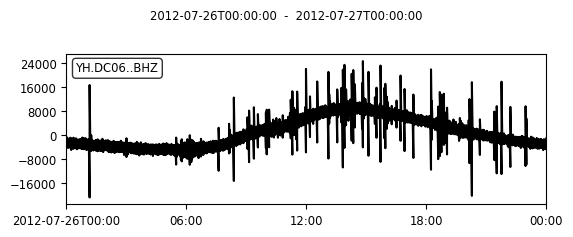

In [34]:
filepaths_raw = sorted(glob(os.path.join(DIRPATH_RAW, "*.mseed")))

# Show
stream = obspy.read(filepaths_raw[2])
stream.plot(size=STREAM_SHOW_SIZE_PX, show=False)  # Show=true shows twice

## Process

This stage load every waveform and apply the processing chain, including a detrend on individual segments (if any), a merge and gap filling over the full day (between the start and end time of the trace), a resampling at a target sampling rate and a sensitivity removal. Overall, this cell executes in about 3 minutes on a desktop machine.

In [35]:
SAMPLING_RATE = 25.0
MAX_SEGMENTS = 10
FREQ_MIN = 2.0
FREQ_MAX = 12.0
TAPER_PERCENT = 0.02
TAPER_TYPE = "cosine"
MSEED_ENCODING = "FLOAT64"

for filepath_waveform in tqdm.tqdm(filepaths_raw, desc="Processing data"):

    # Read trace
    trace = obspy.read(filepath_waveform)[0]

    # Collect start and end times
    starttime, endtime = trace.stats.starttime, trace.stats.endtime

    # Split trace into segments to process them individually
    stream = trace.split()

    # Apply detrend on segments
    stream.detrend("constant")
    stream.detrend("linear")
    stream.taper(TAPER_PERCENT, type=TAPER_TYPE)

    # Merge traces back and fill gaps with zeros
    stream = stream.merge(fill_value=0.0)
    trace = stream[0]
    trace.trim(starttime=starttime, endtime=endtime, pad=True, fill_value=0.0)

    # Resample at target sampling rate
    trace.resample(SAMPLING_RATE)

    # Attach response
    filepath_inventory = f"{trace.stats.network}.{trace.stats.station}.xml"
    filepath_inventory = os.path.join(DIRPATH_RAW, filepath_inventory)
    inventory = obspy.read_inventory(filepath_inventory)
    trace.attach_response(inventory)

    # Remove response
    trace.remove_sensitivity()

    # Detrend
    trace.detrend("constant")
    trace.detrend("linear")
    trace.taper(TAPER_PERCENT, type=TAPER_TYPE)

    # Filter
    trace.filter(
        "bandpass", freqmin=FREQ_MIN, freqmax=FREQ_MAX, zerophase=True
    )
    trace.taper(TAPER_PERCENT, type=TAPER_TYPE)

    # Write processed traces
    _, filename = os.path.split(filepath_waveform)
    filepath_processed_waveform = os.path.join(DIRPATH_PROCESSED, filename)
    trace.write(filepath_processed_waveform, encoding=MSEED_ENCODING)

Processing data: 100%|██████████| 24/24 [01:11<00:00,  2.96s/it]


## Compare raw and processed traces

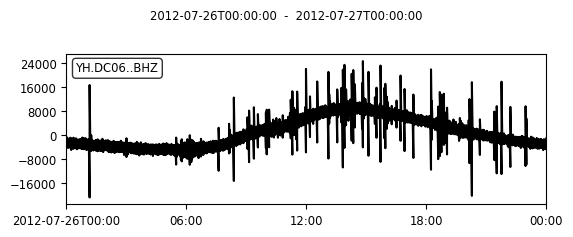

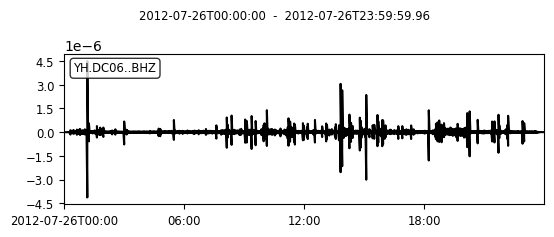

In [38]:
filepath_raw = filepaths_raw[2]
_, filename_raw = os.path.split(filepath_raw)
filepath_processed = os.path.join(DIRPATH_PROCESSED, filename_raw)

for filepath in (filepath_raw, filepath_processed):
    stream = obspy.read(filepath)
    stream.plot(size=STREAM_SHOW_SIZE_PX)